In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import seaborn as sns
from matplotlib import rcParams

In [28]:
# igor's

def info_scaling(u, u_bar, I_max):
    """
    Information scaling function based on:
        I(u) = I_max - 0.5 * log2( (1 + u/u_bar) / (u/u_bar + 2**(-2*I_max)) )
    """
    # Avoid division by zero and invalid values
    u = np.asarray(u)
    u_bar = np.asarray(u_bar)
    I_max = np.asarray(I_max)
    # Set a small epsilon to avoid division by zero
    epsilon = 1e-12
    u_bar_safe = np.where(u_bar == 0, epsilon, u_bar)
    u_over_u_bar = u / u_bar_safe
    numerator = 1 + u_over_u_bar
    denominator = u_over_u_bar + 2 ** (-2 * I_max)
    # Avoid division by zero in denominator
    denominator = np.where(denominator == 0, epsilon, denominator)
    # Avoid negative or zero values inside log2
    ratio = numerator / denominator
    ratio = np.where(ratio <= 0, epsilon, ratio)
    return I_max - 0.5 * np.log2(ratio)

def cell_number_scaling(x, N0, s, I_inf, I_0):
    """
    Cell number scaling function: I(x) = max(I_0, I_inf - (x / N0) ** (-s))
    """
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        # Calculate the scaling term more safely to avoid overflow
        ratio = x / N0
        # Use log-space calculation to avoid overflow
        scaling_term = np.where(
            ratio > 0,
            np.exp(-s * np.log(ratio)),
            0.0
        )
        result = np.where(x > 0, np.maximum(I_0, I_inf - scaling_term), np.nan)
    return result

In [27]:
noise_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
res_df = pd.read_csv('https://raw.githubusercontent.com/igor-sadalski/Scaling-up-measurement-noise-scaling-laws/main/collect_mi_results.csv')

mean_residuals = []
percent_error = []
r2s = []

for row in noise_df.itertuples():

    # compute mean residual
    method = row.method
    metric = row.metric
    size = row.size
    subset = res_df[(res_df['algorithm'] == method) & 
                    (res_df['signal'] == metric) & 
                    (res_df['size'] == size)]

    x_data = subset['umis_per_cell'].values
    y_data = subset['mi_value'].values

    y_fit = info_scaling(x_data, row.fitted_u_bar, row.fitted_I_max)
    residuals = y_data - y_fit
    mean_residual = np.mean(np.abs(residuals))
    mean_residuals.append(mean_residual)
    percent_error.append(100 * mean_residual / np.mean(y_data))
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    r2s.append(r2)

noise_df['mean_residual'] = mean_residuals
noise_df['percent_error'] = percent_error
noise_df['r2'] = r2s

noise_df

,dataset,method,metric,size,fitted_u_bar,fitted_I_max,u_bar_error,I_max_error,mean_residual,percent_error,r2
0,shendure,Geneformer,author_day,100,116.021,0.802,24.386,0.036,0.042823,8.441551,0.954023
1,shendure,Geneformer,author_day,359,207.217,1.243,20.798,0.026,0.022816,3.133489,0.992609
2,shendure,Geneformer,author_day,1291,271.351,1.504,44.861,0.051,0.050278,5.792468,0.981749
3,shendure,Geneformer,author_day,4641,403.606,1.794,42.211,0.038,0.036351,3.708143,0.994379
4,shendure,Geneformer,author_day,16681,342.730,1.938,18.838,0.020,0.026323,2.334671,0.996274
...,...,...,...,...,...,...,...,...,...,...,...
195,PBMC,SCVI,protein_counts,4641,1366.756,3.896,294.280,0.109,0.165778,6.601472,0.968659
196,PBMC,SCVI,protein_counts,10000,3339.672,4.588,419.178,0.072,0.074031,2.643503,0.994256
197,PBMC,SCVI,protein_counts,21544,6967.881,5.162,814.322,0.074,0.048721,1.826903,0.997995
198,PBMC,SCVI,protein_counts,46415,5215.633,5.106,569.952,0.067,0.052509,1.807264,0.997702


In [35]:
cell_df = pd.read_csv('analysis/final_results/cell_scaling_N0_21733.759_s_0.502_I_inf_2.927_I_0_0.730.csv')


percent_error = []
r2s = []
for row in cell_df.itertuples():
    
    # compute mean residual
    method = row.method
    metric = row.metric
    quality = row.quality
    subset = res_df[(res_df['algorithm'] == method) & 
                    (res_df['signal'] == metric) & 
                    (res_df['quality'] == quality)]

    x_data = subset['size'].values
    y_data = subset['mi_value'].values

    mean_residual = row.mean_residual
    percent_error.append(100 * mean_residual / np.mean(y_data))
    
    ss_res = np.sum((y_data - cell_number_scaling(x_data, row.N0, row.s, row.I_inf, row.I_0))**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)

    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0.5 else np.nan
    r2s.append(r2)
cell_df['percent_error'] = percent_error
cell_df['r2'] = r2s

cell_df

,dataset,method,metric,quality,N0,s,I_inf,I_0,mean_residual,percent_error,r2
0,PBMC,Geneformer,celltype.l3,0.001235,10.050,0.487,0.666,0.384,0.059,10.163035,NaN
1,PBMC,Geneformer,celltype.l3,0.002598,43.900,0.931,1.018,0.712,0.026,2.749182,NaN
2,PBMC,Geneformer,celltype.l3,0.005468,10.000,0.472,1.391,0.682,0.054,4.208525,NaN
3,PBMC,Geneformer,celltype.l3,0.011508,88558.015,0.109,2.938,1.336,0.115,7.169167,0.571489
4,PBMC,Geneformer,celltype.l3,0.024220,42.832,0.426,2.115,1.534,0.152,8.021373,0.389254
...,...,...,...,...,...,...,...,...,...,...,...
195,shendure,SCVI,author_day,0.085951,429.288,0.176,1.918,0.642,0.042,3.116599,0.979898
196,shendure,SCVI,author_day,0.158740,288.272,0.169,2.115,0.005,0.062,3.946619,0.946560
197,shendure,SCVI,author_day,0.293173,259.076,0.195,2.217,1.244,0.075,4.311876,0.903064
198,shendure,SCVI,author_day,0.541455,526.118,0.119,2.563,1.328,0.067,3.547248,0.922233


Noise scaling mean R^2 0.9624416708784406


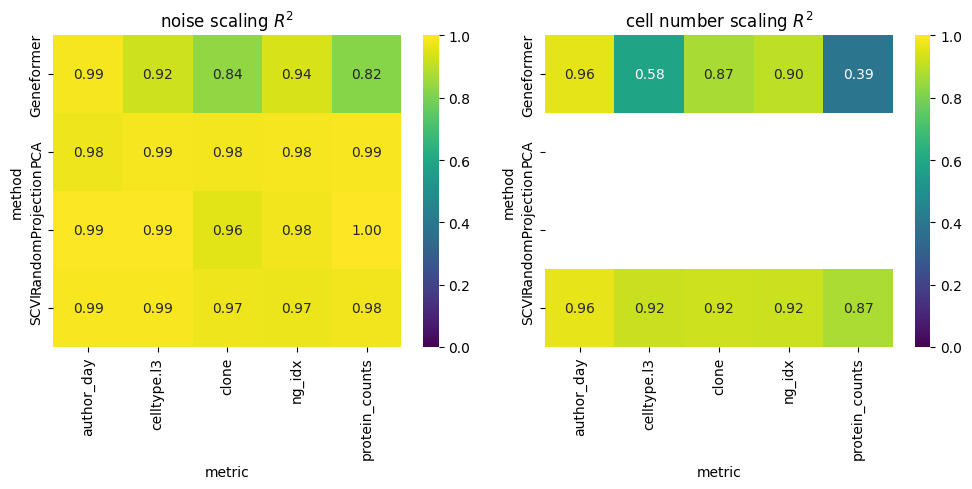

In [46]:
# side by side heatmaps of r2
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
hm = pd.pivot_table(noise_df, index='method', columns='metric', values='r2')
nan_mask = hm.isna()
sns.heatmap(hm, mask=nan_mask, 
            annot=True, fmt=".2f", ax=axes[0], cmap='viridis', vmin=0, vmax=1)
print('Noise scaling mean R^2', hm.mean(axis=None))
axes[0].set_title('noise scaling $R^2$')
hm = pd.pivot_table(cell_df, index='method', columns='metric', values='r2', dropna=False)
nan_mask = hm.isna()
sns.heatmap(hm, mask=nan_mask, 
            annot=True, fmt=".2f", ax=axes[1], cmap='viridis', vmin=0, vmax=1)
axes[1].set_title('cell number scaling $R^2$')
plt.tight_layout()
plt.show()